In [1]:
%matplotlib inline
from datetime import datetime
from enum import Enum
import sqlite3, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!head access.log
!wc -l < access.log

[02/Jan/2015:08:07:32] "GET /click?article_id=162&user_id=5475 HTTP/1.1" 200 4352
[02/Jan/2015:08:08:43] "GET /click?article_id=139&user_id=19550 HTTP/1.1" 200 3078
[02/Jan/2015:08:09:01] "GET /click?article_id=87&user_id=9408 HTTP/1.1" 200 2005
[02/Jan/2015:08:09:18] "GET /click?article_id=175&user_id=9408 HTTP/1.1" 200 3467
[02/Jan/2015:08:09:42] "GET /click?article_id=54&user_id=9531 HTTP/1.1" 200 7097
[02/Jan/2015:08:09:51] "GET /click?article_id=25&user_id=14306 HTTP/1.1" 200 2327
[02/Jan/2015:08:10:00] "GET /click?article_id=46&user_id=10739 HTTP/1.1" 200 2509
[02/Jan/2015:08:10:12] "GET /click?article_id=142&user_id=10325 HTTP/1.1" 200 3430
[02/Jan/2015:08:10:23] "GET /click?article_id=25&user_id=104 HTTP/1.1" 200 2327
[02/Jan/2015:08:10:41] "GET /click?article_id=90&user_id=10739 HTTP/1.1" 200 2123
 1770780


In [76]:
conn = sqlite3.connect('contentDiscovery.db')

def run_sql(sql, showSql = False):
    if showSql:
        print(sql)
    return pd.read_sql_query(sql, conn)

In [20]:
run_sql('select * from users limit 10')

,user_id,email
0,1,portia.johnson@gwxga.com
1,2,marilyn.chavarria@tkvzv.com
2,3,james.conner@xsdeg.com
3,4,dallas.ellis@mmnzc.com
4,5,jimmy.hale@tvsij.com
5,6,david.mcintyre@wkxsv.com
6,7,shirley.thomas@fofqh.com
7,8,elizabeth.stafford@xzlsl.com
8,9,faith.jackson@fqmjp.com
9,10,lou.smith@dcwew.com


In [22]:
run_sql('select * from topics limit 10')

,topic_id,name
0,1,Advertising
1,2,Auditing
2,3,Banks
3,4,Biography
4,5,Bonds
5,6,Bookkeeping
6,7,Budgeting
7,8,Business Development
8,9,Business Ethics
9,10,Business Fashion


In [23]:
run_sql('select * from types limit 10')

,type_id,name
0,1,Blog Post
1,2,Book Review
2,3,Cartoon
3,4,Case Study
4,5,Chart
5,6,Chat
6,7,Clip
7,8,Code
8,9,Comment
9,10,Contest


In [24]:
run_sql('select * from articles limit 10')

,article_id,author_id,topic_id,type_id,submission_time
0,1,13746,72,31,2015-01-01 00:01:14.412609
1,2,3761,94,41,2015-01-01 00:04:11.049356
2,3,17863,30,31,2015-01-01 00:29:34.334229
3,4,5131,39,2,2015-01-01 00:43:55.907851
4,5,14849,9,22,2015-01-01 01:21:04.230631
5,6,10638,49,33,2015-01-01 02:36:18.726190
6,7,946,80,29,2015-01-01 02:42:22.486977
7,8,16144,57,12,2015-01-01 03:18:24.314824
8,9,12393,31,43,2015-01-01 03:30:24.880365
9,10,2814,59,31,2015-01-01 03:31:04.541074


In [25]:
run_sql('select * from email_content limit 10')

,content_id,email_id,user_id,article_id,send_time,week_num
0,1,1,11460,66,2015-01-02 08:06:20.070850,2015_01
1,2,1,11460,135,2015-01-02 08:06:20.070850,2015_01
2,3,1,11460,175,2015-01-02 08:06:20.070850,2015_01
3,4,1,11460,205,2015-01-02 08:06:20.070850,2015_01
4,5,1,11460,218,2015-01-02 08:06:20.070850,2015_01
5,6,1,11460,127,2015-01-02 08:06:20.070850,2015_01
6,7,1,11460,122,2015-01-02 08:06:20.070850,2015_01
7,8,1,11460,106,2015-01-02 08:06:20.070850,2015_01
8,9,1,11460,86,2015-01-02 08:06:20.070850,2015_01
9,10,1,11460,266,2015-01-02 08:06:20.070850,2015_01


In [140]:
c = conn.cursor()
# Create table
c.execute('''
            CREATE TABLE clicks (
            click_time DATETIME NOT NULL,
            week_num varchar not null,
            article_id INTEGER NOT NULL,
            user_id INTEGER NOT NULL,
            status INTEGER NOT NULL,
            bsize INTEGER NOT NULL,
            FOREIGN KEY(user_id) REFERENCES users(user_id),
            FOREIGN KEY(article_id) REFERENCES articles(article_id)
         )''')

In [141]:
# get the pattern
p = re.compile('\[(.*)\] "GET /click\?article_id=(\d*)&user_id=(\d*) HTTP/1.1" (\d*) (\d*)')

# read access.log, and insert row in the clicks table
with open('access.log','r') as f:
    for line in f.readlines():
        ts, article, user, status, bsize = p.match(line).groups()
        ts = datetime.strptime(ts, '%d/%b/%Y:%H:%M:%S')
        c.execute("INSERT INTO clicks VALUES ('%s','%d_%02d',%s,%s,%s,%s)" 
                  %(ts.strftime('%Y-%m-%d %H:%M:%S'), ts.year, int(ts.strftime('%W'))+1, article, user, status, bsize))
    conn.commit()

In [139]:
# c.execute('drop table clicks')
c.execute('alter table email_content add column week_num varchar')
c.execute('''update email_content set week_num = 
            substr(send_time,1,4)||'_'||substr('00'||(strftime('%W',send_time)+1),-2,2)''')
conn.commit()

In [28]:
run_sql('select * from clicks limit 10')

,click_time,week_num,article_id,user_id,status,bsize
0,2015-01-02 08:07:32,2015_01,162,5475,200,4352
1,2015-01-02 08:08:43,2015_01,139,19550,200,3078
2,2015-01-02 08:09:01,2015_01,87,9408,200,2005
3,2015-01-02 08:09:18,2015_01,175,9408,200,3467
4,2015-01-02 08:09:42,2015_01,54,9531,200,7097
5,2015-01-02 08:09:51,2015_01,25,14306,200,2327
6,2015-01-02 08:10:00,2015_01,46,10739,200,2509
7,2015-01-02 08:10:12,2015_01,142,10325,200,3430
8,2015-01-02 08:10:23,2015_01,25,104,200,2327
9,2015-01-02 08:10:41,2015_01,90,10739,200,2123


### load and parse click log

In [74]:
# read raw data, no header
clicks = pd.read_csv('access.log',header=None)
# extract fields
pat = '\[(.*)\] "GET /click\?article_id=(\d*)&user_id=(\d*) HTTP/1.1" (\d*) (\d*)'
clicks = clicks[0].str.extract(pat, expand=True)
# name the columns
clicks.columns=['click_time', 'article_id', 'user_id', 'status', 'bsize']
# convert click_time to datetime format
clicks.click_time = clicks.click_time.map(lambda x: datetime.strptime(x, '%d/%b/%Y:%H:%M:%S'))
# get week number (1-based)
clicks['week'] = clicks.click_time.map(lambda x: '%d_%02d' %(x.year, int(x.strftime('%W'))+1))
# convert id's and status columns to int format
clicks.ix[:,1:-1] = clicks.ix[:,1:-1].apply(pd.to_numeric)
# check data types
clicks.dtypes

### load email data

In [9]:
# this query tells us each article has been sent to a user only once (no duplicate)
sql1 = '''select max(cnt) from (
select count(*) as cnt, user_id, article_id from email_content group by user_id, article_id)'''

sql2 = '''select count(*) from (
select count(*) as cnt, user_id, article_id from email_content group by user_id, article_id)'''

sql3 = 'select count(*) from clicks'

sql4 = 'select count(*) as cnt, week_num from email_content group by week_num'

sql = 'select count(*) as cnt, week_num from email_content group by week_num'
# sql = 'select count(*) as cnt, type_id from articles group by type_id'
# sql = "select substr(send_time, 1,4)||'_'||(strftime('%W',send_time)+1) as wn from email_content limit 10"
sql = 'select count(*) as cnt, status from clicks group by status'





### Gross trend analysis

In [401]:
class SumBy(Enum):
    type = 1
    topic = 2

class GetFor(Enum):
    send = 1
    click = 2


def sql_summary(sumBy, getFor):
    isType = sumBy == SumBy.type
    isSend = getFor == GetFor.send
    col = 'type_id' if isType else 'topic_id'
    return '''
        select count(*) as %s, e.week_num as week, t.name as %s from 
        %s e left join articles a on e.article_id = a.article_id
        join %s t on t.%s = a.%s
        group by e.week_num, t.name
    ''' %('n_send' if isSend else 'n_click', 
          'type' if isType else 'topic',
          'email_content' if isSend else 'clicks',
          'types' if isType else 'topics', col, col)

def sql_join(sumBy):
    sql_send = sql_summary(sumBy, GetFor.send)
    sql_click = sql_summary(sumBy, GetFor.click)
    col = 'type' if sumBy == SumBy.type else 'topic'
    return '''
        select c.n_click, s.n_send, c.n_click/(1.0*s.n_send) as rate, s.week, s.%s 
        from (%s) s left join (%s) c
        on s.week = c.week and s.%s=c.%s    
    ''' %(col, sql_send, sql_click, col, col)

def get_slope(df):
    x = [int(i[5:]) for i in df.week.values]
    return 0 if len(x)<2 else np.polyfit(x,df.n_send.values,1)[0]

sumType = SumBy.topic
ctr = run_sql(sql_join(sumType), True)

# print(sql_join(SumBy.topic))
ctr = ctr[ctr.n_send>=10]
ctr.rate.fillna(0, inplace=True)
ctr.n_click.fillna(0, inplace=True)
groups = ctr.groupby(sumType.name)

# TODO: get rid of outliers


        select c.n_click, s.n_send, c.n_click/(1.0*s.n_send) as rate, s.week, s.topic 
        from (
        select count(*) as n_send, e.week_num as week, t.name as topic from 
        email_content e left join articles a on e.article_id = a.article_id
        join topics t on t.topic_id = a.topic_id
        group by e.week_num, t.name
    ) s left join (
        select count(*) as n_click, e.week_num as week, t.name as topic from 
        clicks e left join articles a on e.article_id = a.article_id
        join topics t on t.topic_id = a.topic_id
        group by e.week_num, t.name
    ) c
        on s.week = c.week and s.topic=c.topic    
    


In [377]:
# groups.agg(lambda x: np.percentile(x.n_send.values, 5))
# ctr.boxplot('n_send',return_type='axes')
# np.polyfit(range(10),np.random.random(10),1)

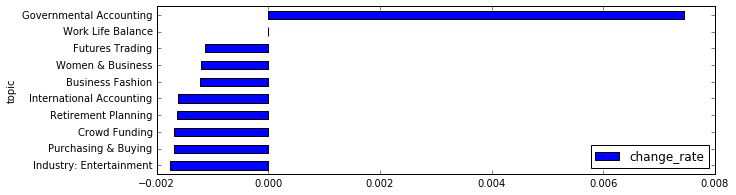

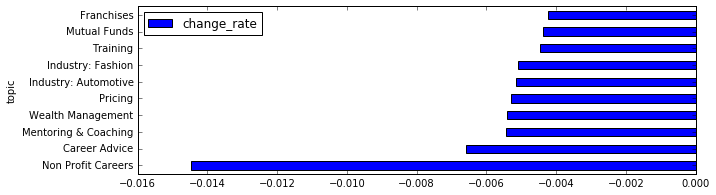

In [436]:
def get_slope(df):
    x = [int(i[5:]) for i in df.week.values]
    return 0 if len(x)<2 else np.polyfit(x,df.rate.values,1)[0]

slopes = groups.agg(get_slope).drop(['n_click','n_send','week'],axis=1)
slopes.columns =['change_rate']
slopes.sort_values(by=['change_rate']).ix[-10:].plot(kind='barh', figsize=(10,3))
slopes.sort_values(by=['change_rate']).ix[:10].plot(kind='barh', figsize=(10,3))

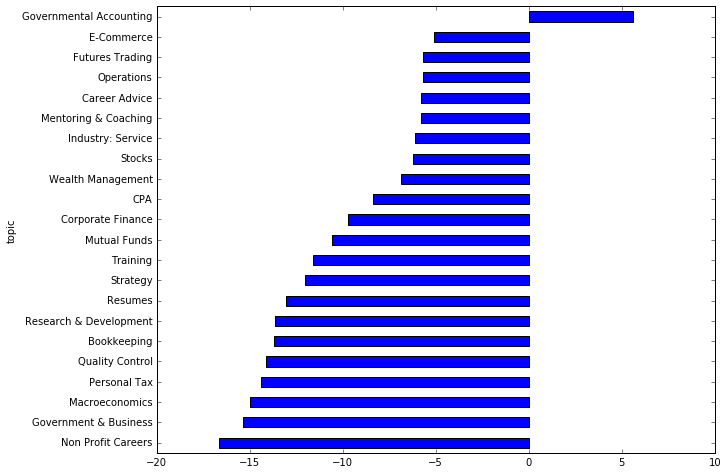

In [390]:
change_pct = groups.mean().join(slopes).apply(lambda x: 100*x.change_rate/x.rate, axis=1)
change_pct[change_pct.abs()>=5].sort_values().plot(kind='barh', figsize=(10,8))

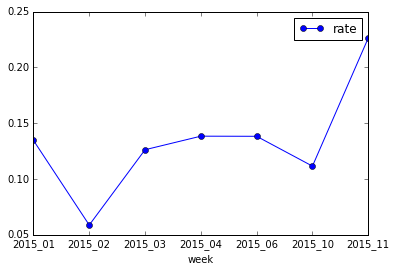

In [416]:
groups.get_group('Governmental Accounting').plot(x='week', y='rate', style='o-') #('Creative Story') #

In [35]:
# check the count when a user clicks his/her own article

run_sql('select count(*) from clicks c left join articles a on c.article_id=a.article_id where c.user_id=a.author_id')

,count(*)
0,95


In [421]:
# run_sql('select count(*) from topics')
run_sql('select count(*) from types')

,count(*)
0,49


In [417]:
# check how many emails per user per week
sql = '''select count(*) as n_email, user_id, week_num from 
        (select distinct user_id,email_id,week_num from email_content) 
        group by user_id, week_num
'''
emails = run_sql(sql)

In [420]:
emails.groupby('week_num').size()

week_num
2015_01    18841
2015_02    20000
2015_03    20000
2015_04    20000
2015_05    20000
2015_06    20000
2015_07    20000
2015_08    20000
2015_09    20000
2015_10    20000
2015_11    20000
2015_12    20000
2015_13    20000
2015_14    19935
dtype: int64

In [425]:
# check how many emails per user (on average) in all weeks
sql = '''select count(*) as n_email, user_id from 
        (select distinct user_id,email_id from email_content) 
        group by user_id
'''
run_sql(sql).mean()

n_email       52.9218
user_id    10000.5000
dtype: float64

# TODO: two analysis modes:
# 1. break down by topic/type
# 2. individual user over time

In [5]:
conn.close()